In [ ]:
from data_fns import load_cifar_10
from estimator import RFClassifier, classical_weights, V1_inspired_weights, relu, parallelized_clf
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import pickle

In [2]:
import dask
from dask.distributed import Client
client = Client(threads_per_worker=5, n_workers=5)
client

/home/bpandey/anaconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35745 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:35233 Dashboard: http://127.0.0.1:35745/status,Cluster Workers: 5 Cores: 25 Memory: 67.32 GB


In [3]:
# load data
X_train, y_train, X_test, y_test = load_cifar_10('data/cifar_10/', grayscale=True)

In [6]:
n_features = sorted(set(np.logspace(0, 3.2, 50).astype('int')))

# weight params
t, l, scale = 5, 2, 1
kwargs = {'t': t, 'l': l, 'scale': scale}
weights_V1 = {'weight_fun': V1_inspired_weights, 'kwargs': kwargs}

kwargs_classical = {'scale': scale}
weights_classical = {'weight_fun': classical_weights, 'kwargs': kwargs_classical}

# params for classification
# sgd = SGDClassifier(loss="squared_hinge", alpha=1, max_iter=200, tol=1e-5, shuffle=True, n_jobs=5,
#                     learning_rate="optimal", early_stopping=True, validation_fraction=0.1, n_iter_no_change=20)
svc = LinearSVC(random_state=20, tol=1e-4, max_iter=500)
b = np.mean(la.norm(X_train) / np.sqrt(X_train.shape[0]))

In [11]:
%%time
results = {}
m = np.zeros_like(n_features, dtype='float')
results['classical'] = {'avg_test_err': m.copy(), 'std_test_err': m.copy()}
results['V1'] = {'avg_test_err': m.copy(), 'std_test_err': m.copy()}
for i, n in enumerate(n_features):

    # classical random features
    params_classical = {'width': n, **weights_classical, 'bias': b, 'nonlinearity': relu, 'clf': svc}
    _, _, results['classical']['avg_test_err'][i], results['classical']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                    params_classical, 
                                                                                                    X_train, y_train, 
                                                                                                    X_test, y_test, 
                                                                                                    n_iters=5)
    
    # haltere inspired
    params_V1 = {'width': n, **weights_V1, 'bias': b, 'nonlinearity': relu, 'clf': svc} 
    _, _, results['V1']['avg_test_err'][i], results['V1']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                params_V1, 
                                                                                                X_train, y_train, 
                                                                                                X_test, y_test, 
                                                                                                n_iters=5)

    print('Iter: %d/%d, V1 test err=%0.2f, RF test err= %0.2f' % (n, n_features[-1],  
                                                                       results['V1']['avg_test_err'][i],
                                                                      results['classical']['avg_test_err'][i]))
    
with open('results/cifar10_clf/cifar10_clf_t=%0.2f_l=%0.2f.pickle' % (t, l), 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

Iter: 1/1584, V1 test err=0.90, RF test err= 0.89
Iter: 2/1584, V1 test err=0.90, RF test err= 0.89
Iter: 3/1584, V1 test err=0.89, RF test err= 0.89
Iter: 4/1584, V1 test err=0.90, RF test err= 0.88
Iter: 5/1584, V1 test err=0.89, RF test err= 0.90
Iter: 6/1584, V1 test err=0.89, RF test err= 0.89
Iter: 7/1584, V1 test err=0.89, RF test err= 0.88
Iter: 8/1584, V1 test err=0.90, RF test err= 0.89
Iter: 9/1584, V1 test err=0.89, RF test err= 0.90
Iter: 11/1584, V1 test err=0.89, RF test err= 0.86
Iter: 12/1584, V1 test err=0.89, RF test err= 0.88
Iter: 14/1584, V1 test err=0.89, RF test err= 0.87
Iter: 17/1584, V1 test err=0.88, RF test err= 0.86
Iter: 20/1584, V1 test err=0.87, RF test err= 0.87
Iter: 23/1584, V1 test err=0.89, RF test err= 0.89
Iter: 27/1584, V1 test err=0.88, RF test err= 0.90
Iter: 31/1584, V1 test err=0.85, RF test err= 0.90
Iter: 36/1584, V1 test err=0.88, RF test err= 0.88
Iter: 42/1584, V1 test err=0.87, RF test err= 0.89
Iter: 49/1584, V1 test err=0.86, RF test

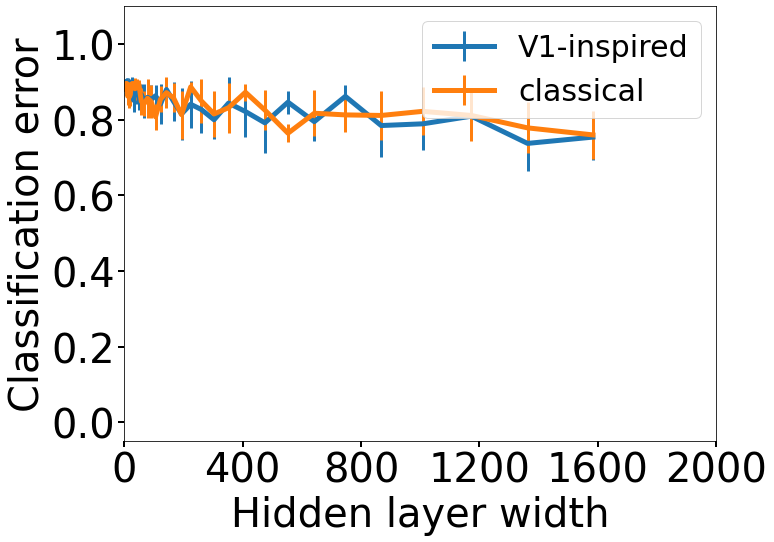

In [15]:
with open('results/cifar10_clf/cifar10_clf_t=%0.2f_l=%0.2f.pickle' % (t, l), 'rb') as handle:
    results = pickle.load(handle)
    
fig = plt.figure(figsize=(10.6, 8))
ax = fig.add_subplot(111)
ax.errorbar(n_features, results['V1']['avg_test_err'], yerr=results['V1']['std_test_err'], fmt='-', 
            label='V1-inspired',  markersize=4, lw=5, elinewidth=3)
ax.errorbar(n_features, results['classical']['avg_test_err'], yerr=results['classical']['std_test_err'], 
            fmt='-', label='classical', markersize=4, lw=5, elinewidth=3)
plt.xlabel('Hidden layer width', fontsize=40)
plt.ylabel('Classification error', fontsize=40)
plt.xlim([0, 2000])
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylim([-0.05, 1.1])
plt.xticks(np.arange(0, 2200, 400))
ax.tick_params(axis = 'both', which = 'major', labelsize = 40, width=2, length=6)

plt.legend(loc = 'upper right', fontsize=30)
# plt.savefig('results/cifar10_clf/cifar10_clf_t=%0.2f_l=%0.2f.png' % (t, l))

## try multiple scales

In [4]:
from estimator import V1_weights_multiple_scales
# n_features = sorted(set(np.logspace(0, 3.3, 50).astype('int')))
n_features = [50, 100, 500, 1000]

# weight params
scale = 1
kwargs = {'scale': scale}
weights_V1 = {'weight_fun': V1_weights_multiple_scales, 'kwargs': kwargs}
weights_classical = {'weight_fun': classical_weights, 'kwargs': kwargs}

# params for classification
# sgd = SGDClassifier(loss="squared_hinge", alpha=1, max_iter=200, tol=1e-5, shuffle=True, n_jobs=5,
#                     learning_rate="optimal", early_stopping=True, validation_fraction=0.1, n_iter_no_change=20)
svc = LinearSVC(random_state=20, tol=1e-4, max_iter=500)
b = np.mean(la.norm(X_train)/ np.sqrt(X_train.shape[0]))

In [5]:
%%time
results = {}
m = np.zeros_like(n_features, dtype='float')
results['classical'] = {'avg_test_err': m.copy(), 'std_test_err': m.copy()}
results['V1'] = {'avg_test_err': m.copy(), 'std_test_err': m.copy()}
for i, n in enumerate(n_features):

    # classical random features
    params_classical = {'width': n, **weights_classical, 'bias': b, 'nonlinearity': relu, 'clf': svc}
    _, _, results['classical']['avg_test_err'][i], results['classical']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                    params_classical, 
                                                                                                    X_train, y_train, 
                                                                                                    X_test, y_test, 
                                                                                                    n_iters=5)
    
    # haltere inspired
    params_V1 = {'width': n, **weights_V1, 'bias': b, 'nonlinearity': relu, 'clf': svc} 
    _, _, results['V1']['avg_test_err'][i], results['V1']['std_test_err'][i] = parallelized_clf(RFClassifier, 
                                                                                                params_V1, 
                                                                                                X_train, y_train, 
                                                                                                X_test, y_test, 
                                                                                                n_iters=5)

    print('Iter: %d/%d, V1 test err=%0.2f, RF test err= %0.2f' % (n, n_features[-1],  
                                                                       results['V1']['avg_test_err'][i],
                                                                      results['classical']['avg_test_err'][i]))
    
with open('results/cifar10_clf/cifar10_clf_t=%0.2f_l=%0.2f_multiscale.pickle' % (t, l), 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

Iter: 50/1000, V1 test err=0.86, RF test err= 0.87
Iter: 100/1000, V1 test err=0.86, RF test err= 0.87
Iter: 500/1000, V1 test err=0.85, RF test err= 0.84


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
